# Trust scores clustering with Gaussian Mixtures


In [1]:
from copy import copy

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from mislabeled.aggregate import mean, oob
from mislabeled.detect import ModelProbingDetector
from mislabeled.ensemble import IndependentEnsemble
from mislabeled.probe import CrossEntropy, Probabilities, Unsupervised

X, y = load_digits(return_X_y=True)

In [2]:
clf = make_pipeline(
    StandardScaler(),
    RBFSampler(gamma="scale", n_components=1000, random_state=1),
    SGDClassifier(loss="log_loss"),
)
clf.fit(X, y).score(X, y)

0.9955481357818586

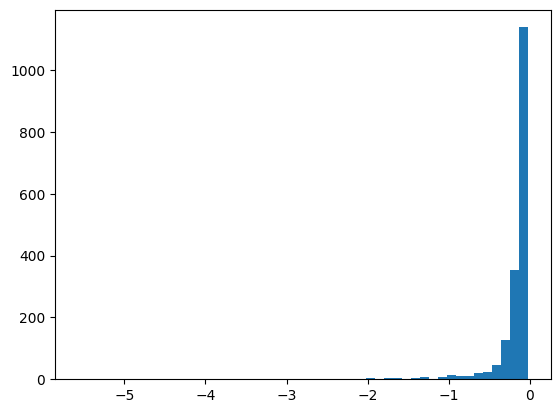

In [4]:
detector = ModelProbingDetector(
    clf,
    probe=CrossEntropy(Probabilities()),
    ensemble=IndependentEnsemble(
        RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1), n_jobs=-1
    ),
    aggregate=oob(mean),
)
supervised_scores = detector.trust_score(X, y)
plt.hist(supervised_scores, bins=50)
plt.show()


Clean and Noisy clusters


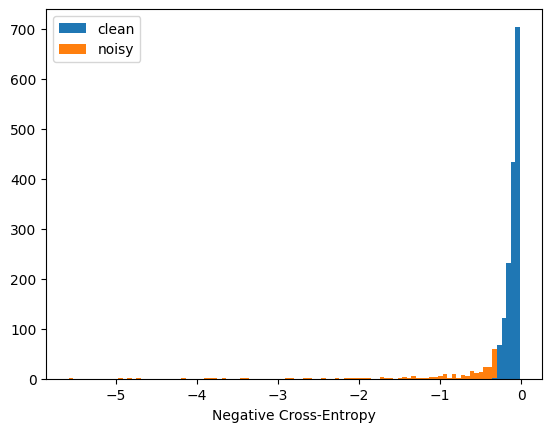

In [5]:
gmm = GaussianMixture(n_components=2, random_state=1).fit(
    supervised_scores.reshape(-1, 1)
)
labels = gmm.predict(supervised_scores.reshape(-1, 1))
plt.hist(
    [supervised_scores[labels == 0], supervised_scores[labels == 1]],
    histtype="barstacked",
    label=["clean", "noisy"],
    bins=100,
)
plt.xlabel("Negative Cross-Entropy")
plt.legend()
plt.show()

Clean, Hard and Noisy clusters

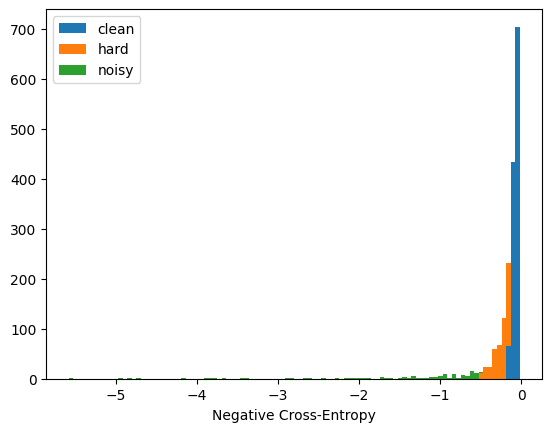

In [6]:
gmm = GaussianMixture(n_components=3, random_state=1).fit(
    supervised_scores.reshape(-1, 1)
)
labels = gmm.predict(supervised_scores.reshape(-1, 1))
plt.hist(
    [
        supervised_scores[labels == 0],
        supervised_scores[labels == 1],
        supervised_scores[labels == 2],
    ],
    histtype="barstacked",
    label=["clean", "hard", "noisy"],
    bins=100,
)
plt.xlabel("Negative Cross-Entropy")
plt.legend()
plt.show()

2D splitting

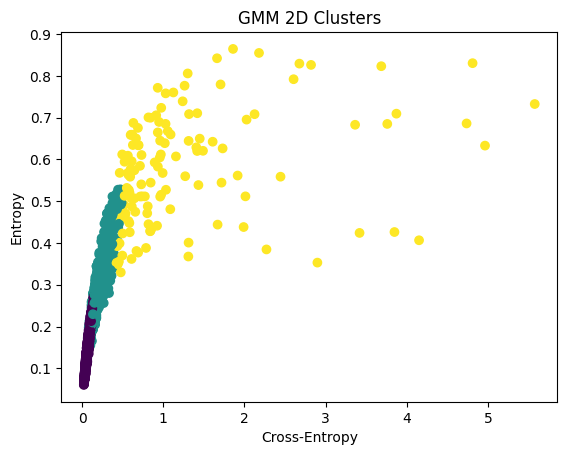

In [7]:
detector_unsupervised = copy(detector)
detector_unsupervised.probe = Unsupervised(detector.probe)
unsupervised_scores = detector_unsupervised.trust_score(X, y)
scores = np.stack((-supervised_scores, -unsupervised_scores), axis=1)
gmm = GaussianMixture(n_components=3, random_state=1).fit(scores)
labels = gmm.predict(scores)
plt.scatter(scores[:, 0], scores[:, 1], c=labels)
plt.title("GMM 2D Clusters")
plt.xlabel("Cross-Entropy")
plt.ylabel("Entropy")
plt.show()